In [ ]:
import kagglehub
import os
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
import torch
from PIL import Image

In [46]:
data_path = kagglehub.dataset_download("pkdarabi/cardetection")

data_path = os.path.join(data_path, "car\\train")
print("Path to dataset files:", data_path)

Path to dataset files: C:\Users\danie\.cache\kagglehub\datasets\pkdarabi\cardetection\versions\5\car\train


In [47]:
def visualize_annotations(data_path):
    def draw_annotations(ax, image, annotations, image_info):
        ax.imshow(image)
        ax.axis("off")
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            ax.add_patch(
                plt.Rectangle(
                    (x, y - 1), w, h, edgecolor="red", linewidth=1, fill=False
                )
            )
            category = coco.loadCats(ann["category_id"])[0]["name"]
            ax.text(
                x,
                y - 5,
                category,
                color="red",
                fontsize=12,
                bbox=dict(facecolor="white", alpha=0.75),
            )
        # ax.set_title(image_info["file_name"])

    annotation_path = os.path.join(data_path, "cocoann.json")
    # Load COCO annotations
    coco = COCO(annotation_path)

    # Create a figure
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    image_paths = []
    for i in range(4):
        # Select a random image
        img_ids = coco.getImgIds()
        image_info = coco.loadImgs(random.choice(img_ids))[0]

        # Get annotations
        ann_ids = coco.getAnnIds(imgIds=image_info["id"])
        annotations = coco.loadAnns(ann_ids)

        # Load image
        image_path = os.path.join(data_path, "images", image_info["file_name"])
        image_paths.append(image_path)
        image = Image.open(image_path).convert("RGB")

        draw_annotations(axes[i // 2, i % 2], image, annotations, image_info)

    plt.tight_layout()
    plt.show()

    return image_paths

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


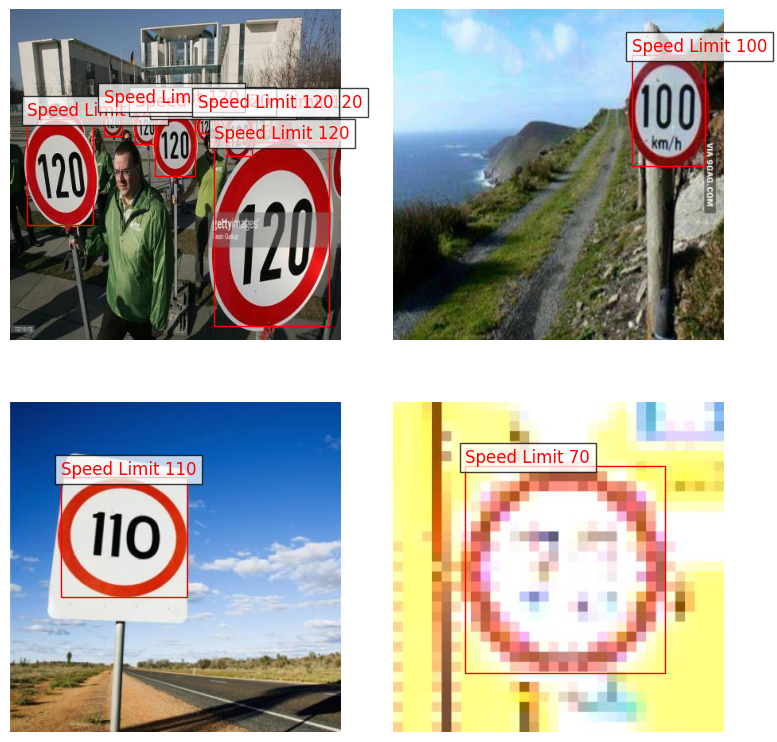

In [48]:
image_paths = visualize_annotations(data_path)

In [49]:
image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_v2_r18vd")
model = RTDetrV2ForObjectDetection.from_pretrained("PekingU/rtdetr_v2_r18vd")

In [50]:
def inference(image_path):
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image
    inputs = image_processor(images=image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Process the outputs
    results = image_processor.post_process_object_detection(
        outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.5
    )

    return results[0]

In [ ]:
def visualize(ax, image_path, results):
    image = Image.open(image_path).convert("RGB")
    ax.imshow(image)
    ax.axis("off")

    for score, label_id, box in zip(results["scores"], results["labels"], results["boxes"]):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin

        ax.add_patch(
            plt.Rectangle((xmin, ymin), width, height, edgecolor="red", linewidth=1, fill=False)
        )
        ax.text(
            xmin,
            ymin - 5,
            f"{model.config.id2label[label_id.item()]}: {score:.2f}",
            color="red",
            fontsize=12,
            bbox=dict(facecolor="white", alpha=0.75)
        )

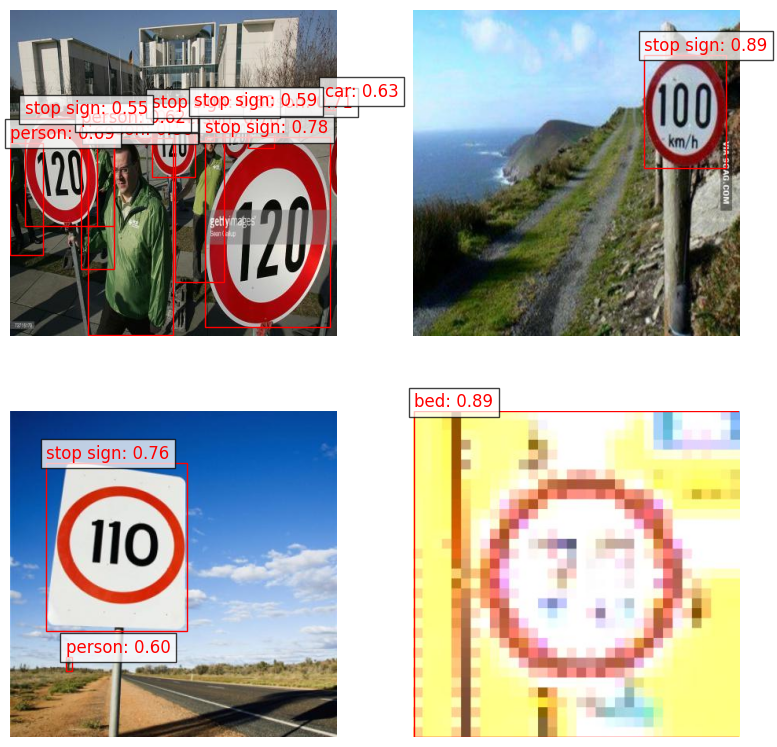

In [53]:
# Create a figure
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, image_path in enumerate(image_paths):
    results = inference(image_path)
    visualize(axes[i // 2, i % 2], image_path, results)

plt.tight_layout()
plt.show()